## Using the MLP model trained on MNIST dataset on the Fashion MNIST dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from load_datasets import load_fasion_mnist


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# device configuration
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.') 
    device = torch.device('cpu')

Using PyTorch version: 2.4.0+cu124
Using GPU, device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# define a function to set all seeds to 0
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(0)

In [4]:
# load the dataset
train_dataset, test_dataset = load_fasion_mnist()
combined_dataset = ConcatDataset([train_dataset, test_dataset])

# Create a DataLoader for the combined dataset
combined_loader = DataLoader(dataset=combined_dataset, batch_size=1, shuffle=True)

print(f"Number of batches in combined_loader: {len(combined_loader)}")
for images, labels in combined_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

Number of batches in combined_loader: 70000
Image batch shape: torch.Size([1, 1, 28, 28])
Label batch shape: torch.Size([1])


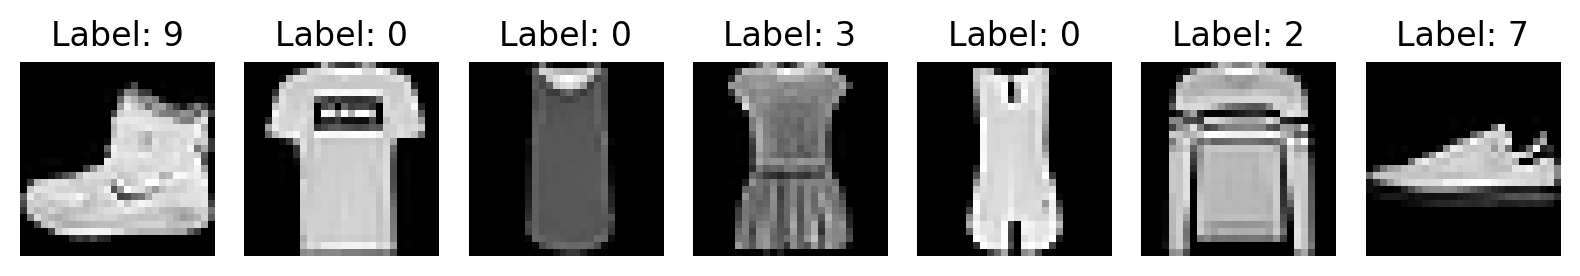

In [5]:
# Plot first few images
fig, axs = plt.subplots(1, 7, figsize=(8, 10))

for i in range(7):
    image, label = combined_dataset[i]
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].set_title(f'Label: {label}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [6]:
input_size = 784
hidden_size = 500
num_classes = 10

In [7]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) for image classification.

    Attributes:
        fc1 (nn.Linear): First fully connected layer.
        relu (nn.ReLU): ReLU activation function.
        fc2 (nn.Linear): Second fully connected layer for output.
    """

    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()                           # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second fully connected layer

    def forward(self, x):
        # Flatten the image 
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        out = self.fc2(x)       # No activation here; we'll apply softmax in the loss function
        return out, x


In [8]:
# Load the model checkpoint
model = MLP(input_size, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load('../models/task-3/mlp_model_98_27.ckpt'))

# Set the model to evaluation mode
model.eval()

C:\Users\Shardul Junagade\AppData\Local\Temp\ipykernel_10324\1597672599.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/task-

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
def predict_model(model, loader):
    model.eval()
    y_pred = []
    y_true = []
    y_prob = []
    hidden_outputs = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs, hidden_output = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_prob.extend(F.softmax(outputs, dim=1).cpu().detach().numpy())
            hidden_outputs.extend(hidden_output.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_prob), np.array(hidden_outputs)

y_true, y_pred, y_prob, hidden_outputs = predict_model(model, combined_loader)

Accuracy: 10.51%
F1 Score: 0.07309
Classification Report:
              precision    recall  f1-score   support

           0       0.01      0.00      0.00      7000
           1       0.23      0.00      0.01      7000
           2       0.01      0.03      0.01      7000
           3       0.28      0.65      0.39      7000
           4       0.02      0.00      0.00      7000
           5       0.07      0.14      0.09      7000
           6       0.14      0.19      0.16      7000
           7       0.01      0.00      0.00      7000
           8       0.25      0.03      0.06      7000
           9       0.00      0.00      0.00      7000

    accuracy                           0.11     70000
   macro avg       0.10      0.11      0.07     70000
weighted avg       0.10      0.11      0.07     70000



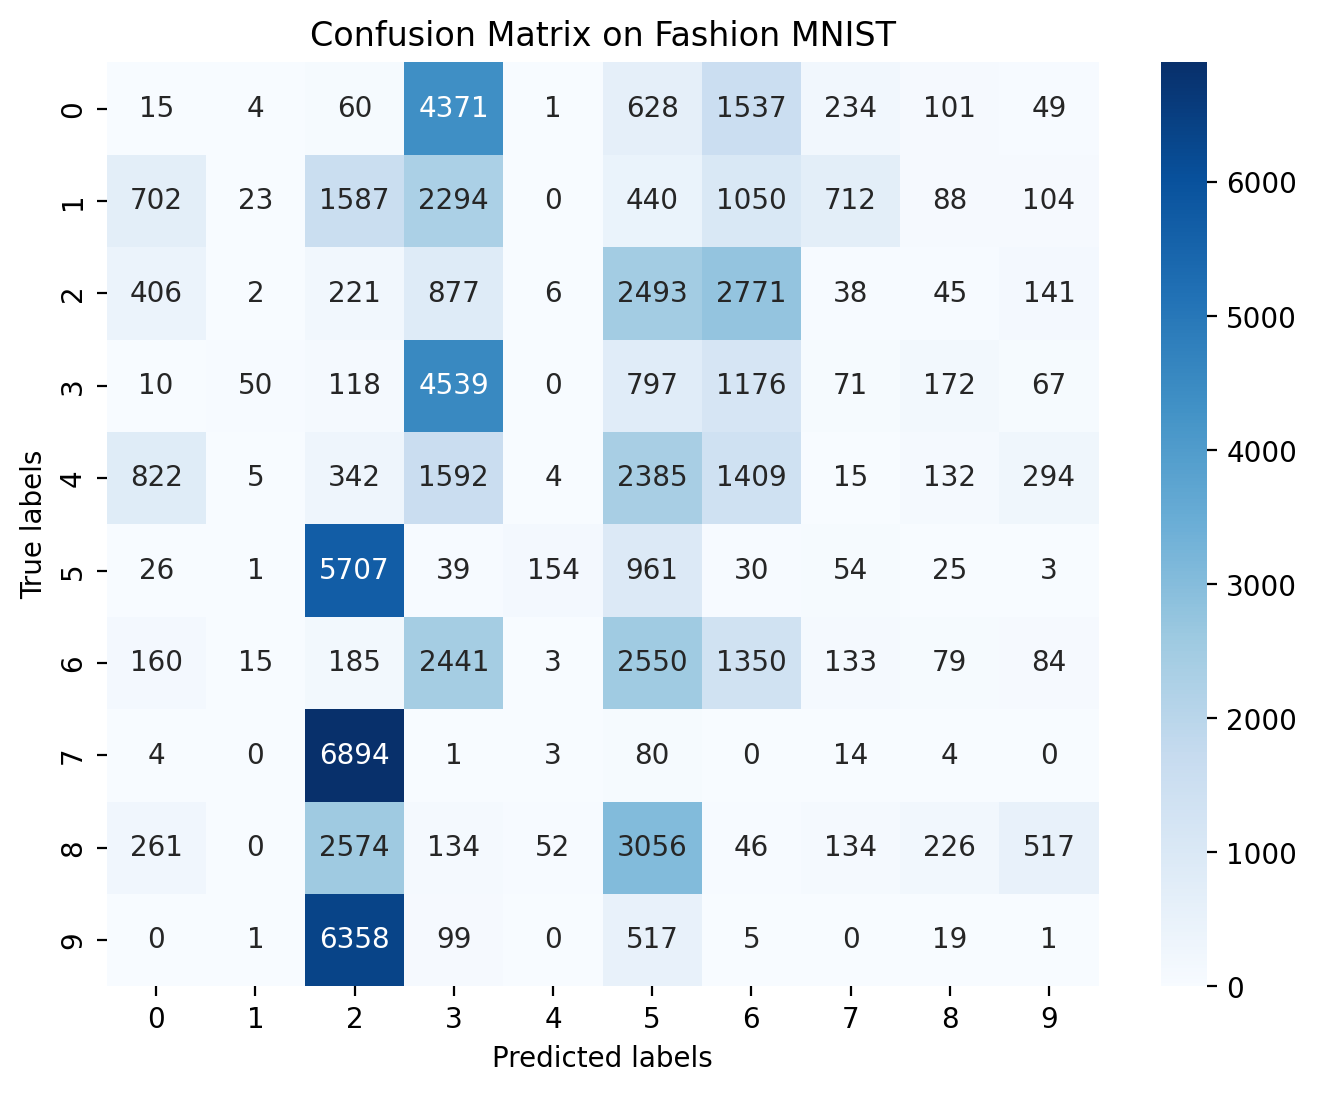

In [10]:
# accuracy, f1 score, confusion matrix, classification report
accuracy = np.mean(y_true == y_pred) * 100
f1 = f1_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}%")
print(f"F1 Score: {f1:.5f}")
# print(f"Confusion Matrix:\n{cm}")
print(f"Classification Report:\n{cr}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix on Fashion MNIST')
plt.show()

## TSNE

In [11]:
# Perform Barnes-Hut t-SNE on the hidden layer output
from openTSNE import TSNE

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
tsne_hidden = tsne.fit(hidden_outputs)


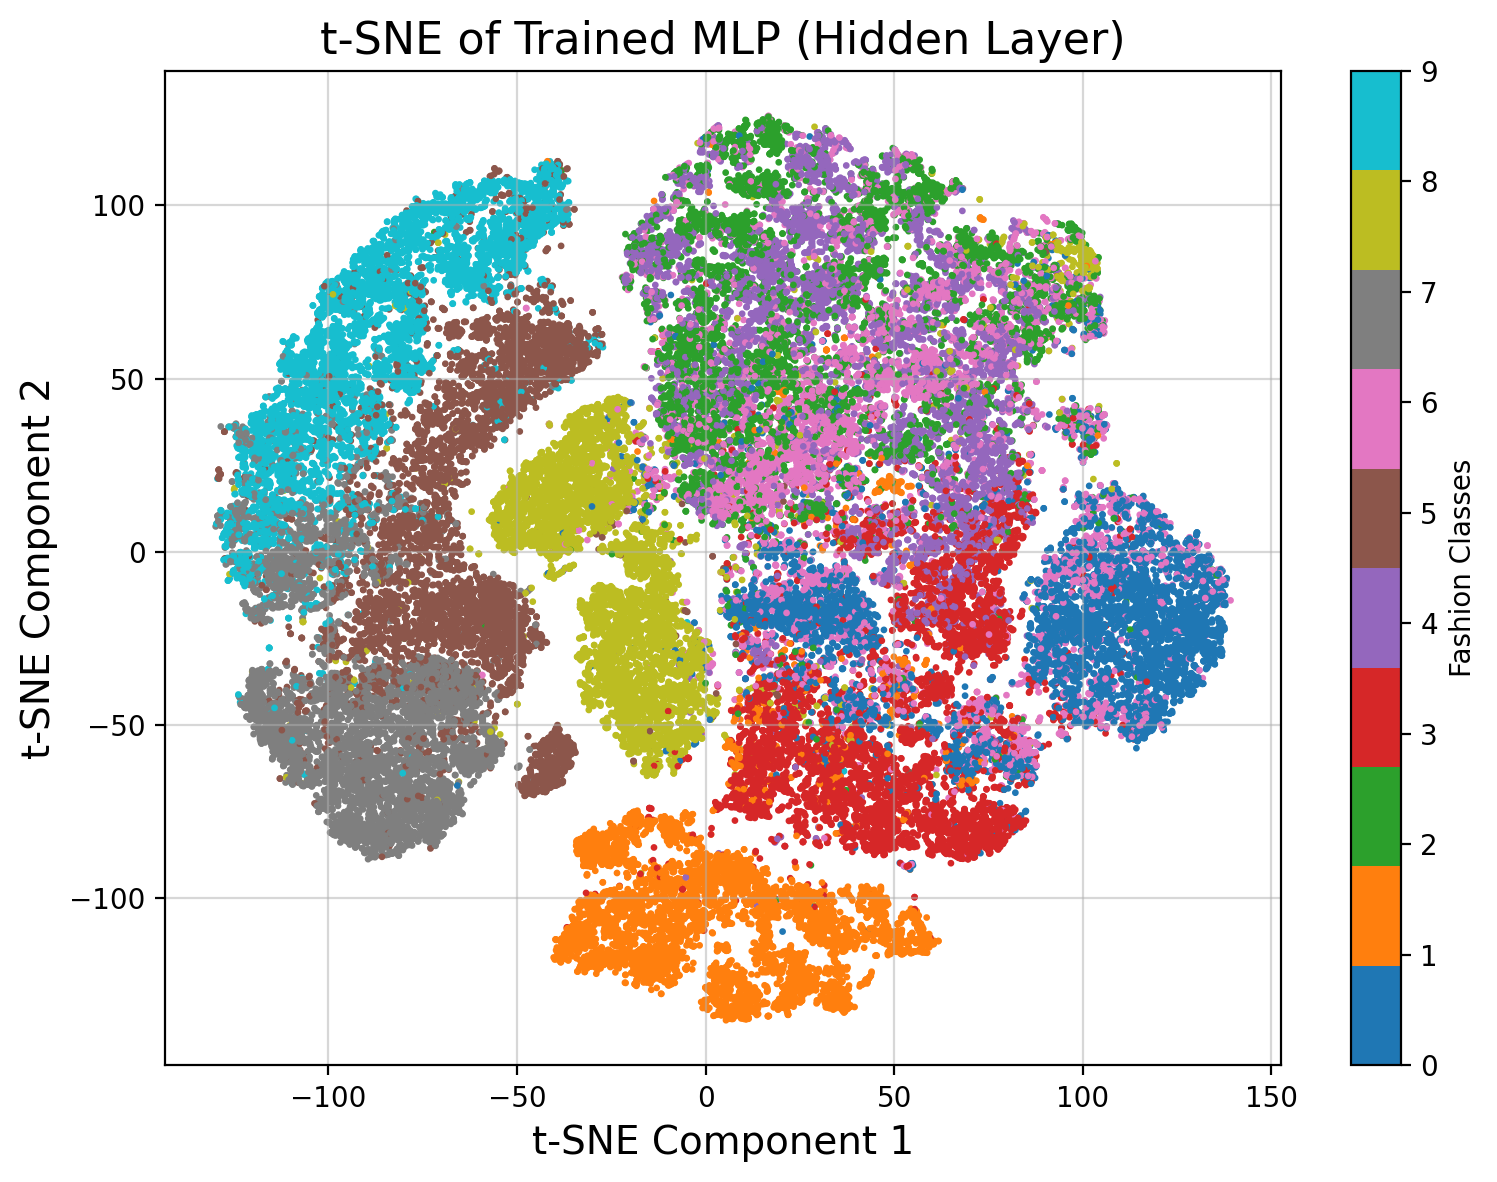

In [14]:
# Plotting t-SNE for trained model
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(tsne_hidden[:, 0], tsne_hidden[:, 1], c=y_true, cmap='tab10', alpha=1, s=2)
ax.set_title('t-SNE of Trained MLP (Hidden Layer)', fontsize=16)
ax.set_xlabel('t-SNE Component 1', fontsize=14)
ax.set_ylabel('t-SNE Component 2', fontsize=14)
ax.grid(True, alpha=0.5)
fig.colorbar(scatter, ax=ax, label='Fashion Classes')

plt.tight_layout()
plt.show()

## Observations on Using the Trained MLP on the Fashion-MNIST Dataset

When the trained MLP model, originally developed for the MNIST dataset, was applied to the Fashion-MNIST dataset, the following observations were made:

- Model Performance: The model achieved an accuracy of approximately 10.51% and a F1 score of 0.073 on the Fashion-MNIST dataset, which is significantly lower than the accuracy and F1 score achieved on the MNIST dataset. This low accuracy indicates that the model is not well-suited to the new dataset.
- The confusion matrix reveals that many predictions are concentrated on a few classes, especially class 2 (Pullover) and class 3 (Coat). This indicates that the model has likely learned to associate some features of Fashion-MNIST images with those of the MNIST digits, leading to systematic misclassifications.

### t-SNE Visualization for Fashion-MNIST
- When comparing the t-SNE visualization of the MNIST embeddings to those of Fashion-MNIST, we can observe differences in clustering patterns:
   - MNIST Clusters: The t-SNE visualization for MNIST displays clear and well-defined clusters, indicating that the model effectively learned to separate digit classes.
   - Fashion-MNIST Overlap: In contrast, the t-SNE visualization for Fashion-MNIST showed more overlap and less distinct clustering. This suggests that the model has not learned robust features that can differentiate between the various clothing items.

## Conclusion

In summary, the application of the trained MLP on the Fashion-MNIST dataset demonstrates significant limitations in the model's ability to generalize across different image domains. The low accuracy and poor clustering in the t-SNE visualization indicate that the model has not effectively adapted to the fashion classification task.